In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py as h5
import numpy as np

from glob import glob
from tqdm import tqdm

from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import ridder

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
from matplotlib.colors import ListedColormap, to_rgba, to_rgb
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import sys
import os

sys.path.append("../../ASTERIA/python/")
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"

sys.path.append("../")
from sne_bsm import parameterized_flux_from_files, units
from sne_bsm.likelihood import find_significance_matrix 
from sne_bsm.flux.parametrize_flux import deserialize

In [3]:
SM_SERIALIZE_FILE = "./data/serialized_sm_flux.h5"
BSM_SERIALIZE_FILE = "./data/serialized_majoran_fluxes.h5"

MODEL1 = "dphi-dEdt-1MeV-gn10dot2-100s-nf"
MODEL2 = "dphi-dEdt-200MeV-gn11dot8-100s-nf"

MODELS = [
    MODEL1,
    MODEL2,
]

COLORS = [
    "mediumturquoise", # MODEL1
    "dodgerblue", # MODEL2
    "hotpink",
    # "red", # SM
]

LABELS = [
    r"$m_{\phi}=1~\mathrm{MeV}$",
    r"$m_{\phi}=200~\mathrm{MeV}$",
]

# Flux plot

## Deserialize the fluxes

In [4]:
with h5.File(SM_SERIALIZE_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])

bsm_fluxes = []

for model in tqdm(MODELS):
# for model in tqdm([MODEL1, MODEL2, MODEL3]):
    with h5.File(BSM_SERIALIZE_FILE, "r") as h5f:
        flux = deserialize(h5f[f"{model}_0"])
    bsm_fluxes.append(flux)

100%|██████████| 2/2 [00:28<00:00, 14.29s/it]


## Make the plot

/Users/jlazar/research/NuTel_SNe_BSM/examples/../sne_bsm/flux/parametrize_flux.py:582: RuntimeWarning: divide by zero encountered in power
  phi_f = lambda e: a * np.power(e / e_exp, alpha) * np.exp(-(alpha+1) * e / e_exp)


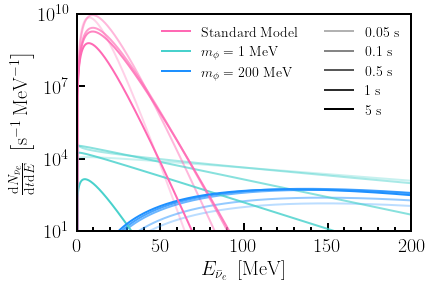

In [5]:
es = np.linspace(0, 200, 400) * units.MeV
ts = np.array([0.05, 0.1, 0.5, 1, 5]) * units["second"]

alphamin = 0.3
alphamax = 1.0

handles = [
    Line2D([], [], color=COLORS[-1], label=r"Standard Model"),
    Line2D([], [], color=COLORS[0], label=r"$m_{\phi}=1~\mathrm{MeV}$"),
    # Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=10~\mathrm{MeV}$"),
    Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=200~\mathrm{MeV}$"),
    Line2D([], [], alpha=0.0),
    Line2D([], [], alpha=0.0),
    Line2D([], [], color="k", alpha=0/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.05}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=1/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=2/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.5}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=3/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=4/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{5}~\mathrm{s}$"),
]


for idx, t in enumerate(ts):
    alpha = idx / (len(ts)-1) * (alphamax - alphamin) + alphamin
    for color, flux in zip(COLORS, bsm_fluxes):
        plt.plot(
            es / units.MeV,
            flux.get_flux(t, es, 1) * units.second * units.MeV,
            color=to_rgb(color) + (alpha,)
        )
    
    # Only plot the SM flux for the first 8 seconds
    if t > 8 * units.second:
        continue
    
    plt.plot(
        es / units.MeV,
        sm_flux.get_flux(t, es, 1) * units.second * units.MeV,
        color=to_rgb(COLORS[-1]) + (alpha,)   
    )

       
plt.ylabel(
    r"$\frac{\mathrm{d}N_{\bar{\nu}_{e}}}{\mathrm{d}t\mathrm{d}E}~\left[\mathrm{s}^{-1}\,\mathrm{MeV}^{-1}\right]$",
    fontsize=20
)
plt.xlabel(
    r"$E_{\bar{\nu}_{e}}~\left[\mathrm{MeV}\right]$"
)
plt.ylim(1e1, 1e10)
plt.xlim(es.min() / units.MeV, es.max() / units.MeV)
plt.semilogy()
plt.legend(
    handles=handles,
    ncol=2,
    fontsize=14,
    framealpha=0.0,
    loc=1,
    # bbox_to_anchor=(1, 1.075)
)
plt.savefig("../figures/majoran_fluxes.pdf")
plt.show()

# Hits and likelihood plot

## Compute the hits from each flux as a function of time

In [6]:
dt = 0.01 * units.second

sm_ts, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="paper_plots.txt",
    dt=dt
)

bsm_ts = None
bsm_hits = []

for flux in bsm_fluxes:
    bsm_ts_tmp, hits = flux.get_hits(
        model_file="paper_plots.txt",
        tmax=100 * units["second"],
        dt=dt
    )
    
    # Make sure we're not doing something goofy with the times
    if bsm_ts is not None:
        if not np.all(bsm_ts_tmp==bsm_ts):
            raise ValueError()

    bsm_ts = bsm_ts_tmp
    bsm_hits.append(hits)
    

bg_hits = flux.get_background(
    shape=bsm_ts.shape,
    model_file="paper_plots.txt",
    tmax=100 * units["second"],
    dt=dt
)

if np.any(sm_ts!=bsm_ts):
    raise ValueError("Hit times are different !")

/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:305: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:305: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:306: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


## Consider the $\Delta\mathrm{LLH}$ when only considering hits in a certain time window

In [7]:
times = []
for hits in tqdm(bsm_hits):
    significance, tmins, dts = find_significance_matrix(
        hits,
        sm_hits,
        bg_hits,
        bsm_ts
    )

    significance.T[::-1][-1] = 0
    if np.any(np.isnan(significance)):
        raise ValueError()
    max_significance = significance.max()

    idxs, jdxs = np.where(significance==max_significance)
    
    times.append((tmins[idxs[0]], dts[jdxs[0]]))

100%|██████████| 2/2 [00:17<00:00,  8.83s/it]


## Interpolate $\mathrm{d}N/\mathrm{d}t$ for plotting

In [8]:
sm_spl = CubicSpline(sm_ts, sm_hits / dt)
noise_spl = CubicSpline(sm_ts, bg_hits / dt)

logspace_ts = np.logspace(-2, 2, 1000) * units.second

bsm_spls = []
for hits in bsm_hits:
    spl = CubicSpline(bsm_ts, hits / dt)
    bsm_spls.append(spl)

## Make the plots

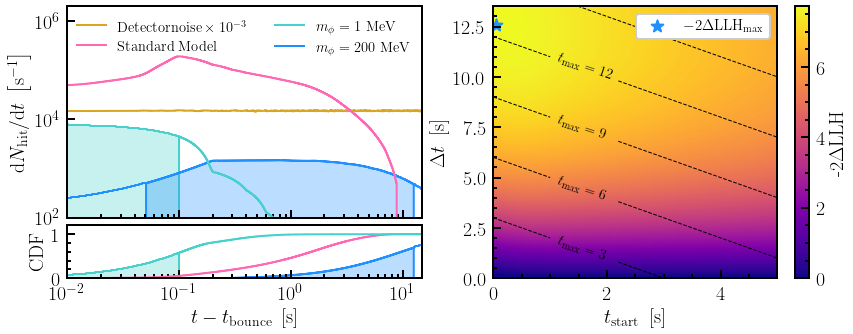

In [10]:
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(2, 2, figure=fig, height_ratios=[4,1], hspace=0.06)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[:, 1])

ax0.step(logspace_ts / units.second, noise_spl(logspace_ts) * units.second / 100, where="post", color="goldenrod", label=r"$\mathrm{Detector noise} \times 10^{-3}$")
ax0.step(logspace_ts / units.second, sm_spl(logspace_ts) * units.second, where="post", color=COLORS[-1], label="Standard Model")
for color, label, spl, tt in zip(COLORS, LABELS, bsm_spls, times):
    m = logspace_ts < tt[0]
    ax0.step(logspace_ts[m] / units.second, spl(logspace_ts[m]) * units.second, where="post", label=label, color=color)
    m = np.logical_and(tt[0] <= logspace_ts, logspace_ts <= tt[1])
    ax0.fill_between(
        logspace_ts[m] / units.second,
        spl(logspace_ts[m]) * units.second, 1e-3,
        edgecolor=color,
        facecolor=to_rgb(color) + (0.3,),
        step="post"
    )
    m = tt[1] < logspace_ts
    ax0.step(logspace_ts[m] / units.second, spl(logspace_ts[m]) * units.second, where="post", color=color)

ax0.loglog()
ax0.set_ylim(1e2, 2e6)
ax0.set_xlim(1e-2, 15)

ax0.set_xticklabels([])
ax0.set_ylabel(r"$\mathrm{d}N_{\mathrm{hit}}/\mathrm{d}t~\left[\mathrm{s}^{-1}\right]$")

ax0.legend(
    fontsize=14.5,
    # bbox_to_anchor=(0.9,1.21),
    loc=1,
    framealpha=0.0,
    ncol=2
)

# Bottom left
x = sm_spl.integrate(0, 8*units.second)
ax1.step(logspace_ts / units.second, [sm_spl.integrate(0, t) / x for t in logspace_ts], where="post", color=COLORS[2])
for color, label, spl, tt in zip(COLORS, LABELS, bsm_spls, times):
    
    x = spl.integrate(0, 100*units.second)
    m = logspace_ts < tt[0]
    ax1.step(logspace_ts[m] / units.second, [spl.integrate(0, t) / x for t in logspace_ts[m]], where="post", color=color)
    m = np.logical_and(tt[0] <= logspace_ts, logspace_ts <= tt[1])
    ax1.fill_between(
        logspace_ts[m] / units.second,
        [spl.integrate(0, t) / x for t in logspace_ts[m]],
        0,
        edgecolor=color,
        facecolor=to_rgb(color) + (0.3,),
        step="post"
    )
    m = tt[1] < logspace_ts
    ax1.step(logspace_ts[m] / units.second, [spl.integrate(0, t) / x for t in logspace_ts[m]], where="post", color=color)


ax1.set_xlim(1e-2, 15)
ax1.set_ylim(0, 1.2)

ax1.set_xlabel(r"$t - t_{\mathrm{bounce}}~\left[\mathrm{s}\right]$")
ax1.set_ylabel(r"$\mathrm{CDF}$")

ax1.semilogx()

## Right subplot
im = ax2.imshow(
    significance.T[::-1],
    aspect="auto",
    extent=[0, 100, 0.001, 25],
)

ax2.scatter(
    times[1][0] / units.second,
    (times[1][0] + times[1][1]) / units.second,
    marker="*",
    color=COLORS[1],
    s=150,
    label=r"$-2\Delta\mathrm{LLH}_{\mathrm{max}}$"
)

ax2.set_xlabel(r"$t_{\mathrm{start}}~\left[\mathrm{s}\right]~$")
ax2.set_ylabel(r"$\Delta t~\left[\mathrm{s}\right]$")

ax2.set_xlim(0, 5)
ax2.set_ylim(0, 13.5)

for x in [3, 6, 9, 12]:
    ax2.plot(np.linspace(0, 1), x - np.linspace(0, 1), color="k", ls="--", lw=1)
    ax2.plot(np.linspace(2.2, 10), x - np.linspace(2.2, 10), color="k", ls="--", lw=1)
    ax2.text(1.1, x-2.1, r"$t_{\mathrm{max}} = %d $" % x, fontsize=14.5, rotation=-18.5)
    
ax2.plot(np.linspace(1.0, 10), 15 - np.linspace(1.0, 10), color="k", ls="--", lw=1)

cbar = plt.colorbar(im, label=r"-2$\Delta \mathrm{LLH}$")
ax2.legend(loc=1, fontsize=15, framealpha=1.0)

plt.savefig("../figures/hits_and_likelihood.pdf")

plt.show()

# Majoran sensitity plot

## Interpolate the CSVs so that we can fill between

In [11]:
no_highe_upper = np.genfromtxt("./data/no_high_e_upper.csv", delimiter=",")
no_hoghe_lower = np.genfromtxt("./data/no_high_e_lower.csv", delimiter=",")

sn_1987a_upper = np.genfromtxt("./data/sn_1987a_eloss_upper.csv", delimiter=",")
sn_1987a_lower = np.genfromtxt("./data/sn_1987a_eloss_lower.csv", delimiter=",")

bounds = [
    no_highe_upper,
    no_hoghe_lower,
    sn_1987a_upper,
    sn_1987a_lower
]

little_big_m = np.inf
big_little_m = 0
spls = []
for bound in bounds:
    sorter = np.argsort(bound[:, 0])
    bound = bound[sorter]
    spl = CubicSpline(np.log(bound[:,0]), np.log(bound[:,1]))
    spls.append(spl)
    if bound[:, 0].max() < little_big_m:
        little_big_m = bound[:, 0].max()
    if bound[:, 0].min() > big_little_m:
        big_little_m = bound[:, 0].min()

ms = np.logspace(np.log10(big_little_m), np.log10(little_big_m))

## Make the plot

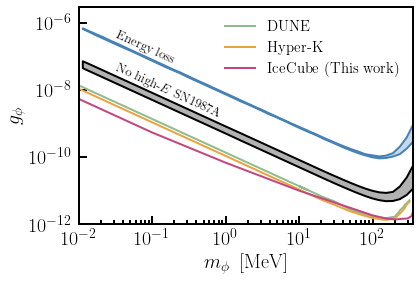

In [12]:
dune_sensitivies = np.genfromtxt("./data/dune_sensitivity.csv", delimiter=",")
hk_sensitivies = np.genfromtxt("./data/hyper_k_sensitivity.csv", delimiter=",")

with h5.File("./data/results.h5") as h5f:
    masses = h5f["majoran_sensitivity"]["masses"][:]
    couplings = h5f["majoran_sensitivity"]["couplings"][:]
    
fig, ax = plt.subplots()

ax.fill_between(
    ms,
    np.exp(spls[2](np.log(ms))) / ms,
    np.exp(spls[3](np.log(ms))) / ms,
    # label="Energy loss",
    edgecolor="steelblue",
    facecolor=to_rgb("steelblue") + (0.3,)
)
ax.fill_between(
    ms,
    np.exp(spls[0](np.log(ms))) / ms,
    np.exp(spls[1](np.log(ms))) / ms,
    # label=r"No high-$E$ SN1987A",
    edgecolor="k",
    facecolor=to_rgb("k") + (0.3,)
)

# plt.plot(masses, couplings, label=" ", color="#6c2624", alpha=0) # Extremely stupid hack
ax.plot(dune_sensitivies[:, 0], dune_sensitivies[:, 1] / dune_sensitivies[:, 0], label="DUNE", color="darkseagreen")
ax.plot(hk_sensitivies[:, 0], hk_sensitivies[:, 1] / hk_sensitivies[:, 0], label="Hyper-K", color="#eba33e")
ax.plot(masses, couplings, label="IceCube (This work)", color="#c2477f")

ax.text(3e-2, 6e-8, "Energy loss", rotation=-24.5, fontsize=13)
ax.text(3e-2, 1.5e-9, r"No high-$E$ SN1987A", rotation=-24.5, fontsize=13)

ax.set_xlabel(r"$m_{\phi}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$g_{\phi}$")

ax.legend(fontsize=15, ncol=1, framealpha=0)

ax.set_xlim(1e-2, 360)
ax.set_ylim(1e-12, 3e-6)

ax.loglog()

plt.savefig("../figures/majoran_sensitivity.pdf")
plt.show()

# Magnetic moment sensitivity plot

## Load up the exclusion data

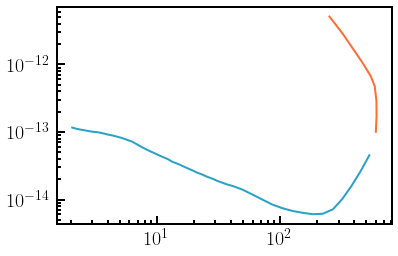

In [ ]:


plt.plot(new_excl[:splitat, 0], new_excl[:splitat, 1]/1e3)
plt.plot(new_excl[splitat:, 0], new_excl[splitat:, 1]/1e3)
plt.loglog()
plt.show()

150.53914284816503

In [ ]:
np.exp(new_excl_interp0(np.log(20)))

2.6375056264059873e-14

In [129]:
# These are the limits from ArXiv:2302.10965
lb1 = np.genfromtxt("./data/magnetic_moment_lower_exc_1.csv", delimiter=",")
ub1 = np.genfromtxt("./data/magnetic_moment_upper_exc_1.csv", delimiter=",")
lb2 = np.genfromtxt("./data/magnetic_moment_upper_exc_2.csv", delimiter=",")

lb1_interp = interp1d(np.log(lb1[:, 0]), np.log(lb1[:, 1]), fill_value="extrapolate")
lb2_interp = interp1d(np.log(lb2[:, 0]), np.log(lb2[:, 1]), fill_value="extrapolate")
ub1_interp = interp1d(np.log(ub1[:, 0]), np.log(ub1[:, 1]), fill_value="extrapolate")

# These are the limits from 2402.#####
new_excl = np.genfromtxt("/Users/jlazar/Downloads/new_exclusion.csv", delimiter=",")
s = np.sign(np.diff(new_excl[:, 0]))
splitat = np.argwhere([x!=y for x, y in zip(s, s[1:])])[0][0]

new_excl_interp0 = interp1d(
    np.log(new_excl[:splitat, 0]),
    np.log(new_excl[:splitat, 1] / 1e3),
    fill_value="extrapolate"
)
new_excl_interp1 = interp1d(
    np.log(new_excl[splitat:, 0]),
    np.log(new_excl[splitat:, 1] / 1e3),
    fill_value="extrapolate"
)

# f = lambda lx: np.exp(new_excl_interp0(lx)) - np.exp(ub1_interp(lx))

# m0 = np.exp(ridder(f, np.log(20), np.log(300)))

masses1 = np.logspace(np.log10(lb1[:, 0].min()), np.log10(min(lb1[:, 0].max(), ub1[:, 0].max())))
masses2 = np.logspace(np.log10(lb1[:, 0].min()), np.log10(lb2[:, 0].max()))
masses3 = np.logspace(
    np.log10(5),
    np.log10(new_excl[:, 0].max()),
)

xs = np.hstack((lb1[:, 0], ub1[::-1, 0], lb2[:, 0]))
ys = np.hstack((lb1[:, 1], ub1[::-1, 1], lb2[:, 1]))

dune_sensitivies = np.genfromtxt("./data/dune_magnetic_moment_sens.csv", delimiter=",")
hk_sensitivies = np.genfromtxt("./data/hyper_magnetic_moment_sens.csv", delimiter=",")

dune_spl = interp1d(np.log(dune_sensitivies[:, 0]), np.log(dune_sensitivies[:, 1]))
hk_spl = interp1d(np.log(hk_sensitivies[:, 0]), np.log(hk_sensitivies[:, 1]))

dune_f = lambda lx: np.exp(dune_spl(lx)) - np.exp(ub1_interp(lx))
hk_f = lambda lx: np.exp(hk_spl(lx)) - np.exp(ub1_interp(lx))

with h5.File("./data/results.h5") as h5f:
    masses = h5f["magnetic_moment_sensitivity"]["masses"][:]
    couplings = h5f["magnetic_moment_sensitivity"]["couplings"][:]
    
ic_spl = interp1d(np.log(masses), np.log(couplings))
ic_f = lambda lx: np.exp(ic_spl(lx)) - np.exp(ub1_interp(lx))

hk_m = np.exp(ridder(hk_f, np.log(100), np.log(200)))
ic_m = np.exp(ridder(ic_f, np.log(100), np.log(200)))
dune_m = np.exp(ridder(dune_f, np.log(100), np.log(200)))
print(hk_m, ic_m, dune_m)

132.2082784551034 104.18210934273374 122.65459915864342


## Make the plot

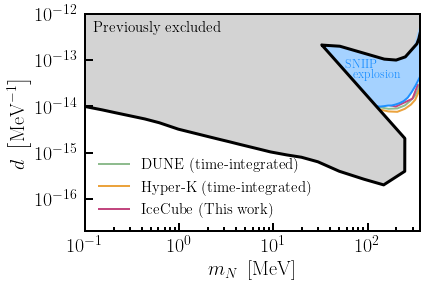

In [146]:
# Option 2
fig, ax = plt.subplots()

ax.fill_between(
    masses3,
    np.exp(new_excl_interp0(np.log(masses3))),
    np.exp(new_excl_interp1(np.log(masses3))),
    # edgecolor="dodgerblue",
    facecolor="white"
)

ax.fill_between(
    masses3,
    np.exp(new_excl_interp0(np.log(masses3))),
    np.exp(new_excl_interp1(np.log(masses3))),
    edgecolor="dodgerblue",
    facecolor=to_rgb("dodgerblue") + (0.4,)
)


ax.fill_between(
    masses1,
    np.exp(lb1_interp(np.log(masses1))),
    np.exp(ub1_interp(np.log(masses1))),
    facecolor="lightgray",
)

ax.fill_between(
    masses2,
    np.exp(lb2_interp(np.log(masses2))), 
    1,
    facecolor="lightgray",
)
ax.plot(xs, ys, lw=3, color="k")

# ax.plot(new_excl[:splitat, 0], new_excl[:splitat, 1]/1e3)
# ax.plot(new_excl[splitat:, 0], new_excl[splitat:, 1]/1e3)

ax.plot(dune_sensitivies[:, 0], dune_sensitivies[:, 1], label="DUNE (time-integrated)", color="darkseagreen", zorder=0)
ax.plot(hk_sensitivies[:, 0], hk_sensitivies[:, 1], label="Hyper-K (time-integrated)", color="#eba33e", zorder=0)
ax.plot(masses, couplings, label="IceCube (This work)", color="#c2477f", zorder=0)

ax.set_xlabel(r"$m_{N}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$d~\left[\mathrm{MeV}^{-1}\right]$")

ax.legend(fontsize=15, ncol=1, framealpha=0, loc=3)

ax.set_xlim(0.1, 360)
ax.set_ylim(2e-17, 1e-12)

ax.text(1.2e-1, 4e-13, "Previously excluded", fontsize=15, zorder=11)
ax.text(58, 7e-14, "SNIIP ", fontsize=12, zorder=14, color="dodgerblue")
ax.text(70, 4e-14, "explosion", fontsize=12, zorder=14, color="dodgerblue")

ax.loglog()

ax.set_yticks([1e-12, 1e-13, 1e-14, 1e-15, 1e-16])

# plt.savefig("../figures/magnetic_moment_sensitivity_no_lines.pdf")
plt.savefig("../figures/magnetic_moment_sensitivity.pdf")
plt.show()